## Pertanyaan:
    1. Bikin chart yang menjelaskan behaviour profil dalma membeli barang (Tanggal dalam Bulan)
    2. Nama barang yang terbanyak dibeli di setiap profil?

In [1]:
# Importing pandas, psycopg2, sqlalchemy, matplotlib
import pandas as pd          # to read data in python with dataframe format
import psycopg2              # PostgreSQL database adapter
import sqlalchemy            # Toolkit and Object Relational Mapper that gives full power and flexibility of SQL
import matplotlib.pyplot as plt     # Visualization
from sqlalchemy import create_engine

%matplotlib inline

In [2]:
# Importing plotly, graph_objs, grid_objs
import plotly
plotly.tools.set_credentials_file(username='xxxxxxxx', api_key='xxxxxxxxxxx')

import plotly.plotly as py
from plotly.grid_objs import Grid, Column
from plotly.tools import FigureFactory as ff
import plotly.graph_objs as go
plotly.offline.init_notebook_mode(connected=True)

In [3]:
# connecting postgres offline
# postgres string ('postgresql://{username}:{password}@{ipaddress}:{port}/{dbname}')
postgres_connection = ('postgresql://xxxxxxxxxxxxxxx')
# Create the connection
cnx = create_engine(postgres_connection)
df = pd.read_sql_query("""SELECT * from customer""", cnx)
df.head()

# Connect postgres online
# Postgres username, password, and database name
POSTGRES_ADDRESS = 'xxxxxxxxxxxxxxxxxxx'
POSTGRES_PORT = 'xxxxxxxxxx'
POSTGRES_USERNAME = 'xxxxxxxx'
POSTGRES_DBNAME = 'xxxxxxx'
POSTGRES_PASSWORD = 'xxxxxxxxxx'

postgres_str = ('postgresql://{username}:{password}@{ipaddress}:{port}/{dbname}'.format(
    username=POSTGRES_USERNAME,
    password=POSTGRES_PASSWORD,
    ipaddress=POSTGRES_ADDRESS,
    port=POSTGRES_PORT,
    dbname=POSTGRES_DBNAME))

# Create the connection
cnx_online = create_engine(postgres_str)
df_online = pd.read_sql_query("""SELECT * from customer""",cnx_online)
df_online.head()

,customer_id,country
0,12346,United Kingdom
1,12347,Iceland
2,12348,Finland
3,12349,Italy
4,12350,Norway


In [4]:
df_transaction = pd.read_sql_query("""SELECT * from transaction""",cnx)
df_transaction.head()

,trx_id,invoice_no,stock_code,quantity,invoice_date,unit_price,customer_id
0,1,536365,85123A,6,2010-12-01 08:26:00,2.55,17850.0
1,2,536365,71053,6,2010-12-01 08:26:00,3.39,17850.0
2,3,536365,84406B,8,2010-12-01 08:26:00,2.75,17850.0
3,4,536365,84029G,6,2010-12-01 08:26:00,3.39,17850.0
4,5,536365,84029E,6,2010-12-01 08:26:00,3.39,17850.0


In [5]:
# create day of week name transaction


df_time_of_day = pd.read_sql_query("""select *,
case
    when extract(dow from invoice_date) = 0 then 'Sunday'
    when extract(dow from invoice_date) = 1 then 'Monday'
    when extract(dow from invoice_date) = 2 then 'Tuesday'
    when extract(dow from invoice_date) = 3 then 'Wednesday'
    when extract(dow from invoice_date) = 4 then 'Thursday'
    when extract(dow from invoice_date) = 5 then 'Friday'
    when extract(dow from invoice_date) = 6 then 'Saturday'
end as day_of_week_name,
case
    when extract(hour from invoice_date) between 0 and 11 then 'morning'
    when extract(hour from invoice_date) between 11 and 18 then 'afternoon'
    when extract(hour from invoice_date) between 18 and 24 then 'night'
end as time_of_day
    from transaction""", cnx)
df_time_of_day.head()

,trx_id,invoice_no,stock_code,quantity,invoice_date,unit_price,customer_id,day_of_week_name,time_of_day
0,1,536365,85123A,6,2010-12-01 08:26:00,2.55,17850.0,Wednesday,morning
1,2,536365,71053,6,2010-12-01 08:26:00,3.39,17850.0,Wednesday,morning
2,3,536365,84406B,8,2010-12-01 08:26:00,2.75,17850.0,Wednesday,morning
3,4,536365,84029G,6,2010-12-01 08:26:00,3.39,17850.0,Wednesday,morning
4,5,536365,84029E,6,2010-12-01 08:26:00,3.39,17850.0,Wednesday,morning


In [6]:
# Customer transaction recency dengan fungsi agregat

df_recency = pd.read_sql_query(""" 
with customer_trx as (select customer_id, date(invoice_date) invoice_date,
count(distinct(invoice_no)) total_order,
count(distinct(date(invoice_date))) total_date
from transaction
where customer_id is not null
group by 1,2
order by 1,2),

customer_day_diff as (select customer_id, invoice_date, total_order, total_date,
date(invoice_date)-date(lag(invoice_date,1) over (partition by customer_id
order by invoice_date)) as day_diff
from customer_trx),

cust_recency as (select customer_id, sum(total_order) total_order, sum(total_date) total_day,
avg(day_diff) as avg_recency, max(day_diff) max_recency, min(day_diff) min_recency 
from customer_day_diff
where day_diff is not null and customer_id is not null
group by 1
order by 1)

select *, case when avg_recency < (SELECT PERCENTILE_CONT(0.5) WITHIN
GROUP(ORDER BY avg_recency) FROM cust_recency) then 'low' else 'high' end as recency_level
from cust_recency
""", cnx)

df_recency.head() 

,customer_id,total_order,total_day,avg_recency,max_recency,min_recency,recency_level
0,12347,6.0,6.0,60.833333,90,37,high
1,12348,3.0,3.0,94.333333,173,40,high
2,12352,10.0,6.0,43.333333,182,5,low
3,12356,2.0,2.0,151.500000,223,80,high
4,12358,1.0,1.0,149.000000,149,149,high


In [7]:
df_recency['recency_level'].value_counts()

high    1497
low     1494
Name: recency_level, dtype: int64

In [8]:
df_monetize = pd.read_sql_query("""
with
customer_monitize as (select customer_id,
count(distinct invoice_no) as total_order,
sum(unit_price * quantity) as total_spend,
sum(unit_price * quantity)/count(distinct(invoice_no)) as basketsize,
max(unit_price * quantity)/count(distinct(invoice_no)) as max,
min(unit_price * quantity)/count(distinct(invoice_no)) as min,
avg(unit_price * quantity)/ count(distinct(invoice_no)) as avg
from transaction
where customer_id is not null and quantity > 0
group by customer_id order by basketsize desc)


select *,case
when basketsize < (SELECT PERCENTILE_CONT(0.5) WITHIN
GROUP(ORDER BY basketsize) FROM customer_monitize) then 'low' else 'high'
end as monitize_level
from customer_monitize;
""",cnx)

df_monetize.head()

,customer_id,total_order,total_spend,basketsize,max,min,avg,monitize_level
0,16446,2,168472.50,84236.250000,84234.8,0.625,28078.750000,high
1,12346,1,77183.60,77183.600000,77183.6,77183.600,77183.600000,high
2,15749,3,44534.30,14844.766667,2179.8,910.000,1484.476667,high
3,15098,3,39916.50,13305.500000,12990.0,99.000,4435.166667,high
4,12357,1,6207.67,6207.670000,237.6,10.080,47.386794,high


In [9]:
df_monetize['monitize_level'].value_counts()

high    2170
low     2169
Name: monitize_level, dtype: int64

In [10]:
# Customer transaction frequency

df_frequency = pd.read_sql_query("""
with customer_frequency as (select customer_id,
extract(year from invoice_date) year_number,
extract(month from invoice_date) month_number,
count(distinct(invoice_no)) total_order 
from transaction
where customer_id is not null
group by 1,2,3
order by 1,2,3),

customer_freq2 as (select customer_id, avg(total_order) avg_total_order_monthly,
max(total_order) max_total_order,
min(total_order) min_total_order,
count(customer_id) total_active_month,
sum(total_order) total_all_order
from customer_frequency
group by 1)


select *, case
when total_all_order < (SELECT PERCENTILE_CONT(0.5) WITHIN
GROUP(ORDER BY total_all_order) from customer_freq2) then 'low' else 'high'
end as frequency_level
from customer_freq2""", cnx)

df_frequency.head()

,customer_id,avg_total_order_monthly,max_total_order,min_total_order,total_active_month,total_all_order,frequency_level
0,16592,2.375000,4,1,8,19.0,high
1,14173,1.333333,2,1,3,4.0,high
2,13527,1.600000,3,1,5,8.0,high
3,14067,1.000000,1,1,2,2.0,low
4,12502,1.000000,1,1,5,5.0,high


In [11]:
df_frequency['frequency_level'].value_counts()

high    2242
low     2130
Name: frequency_level, dtype: int64

In [12]:
df_recency.describe()

,customer_id,total_order,total_day,avg_recency,max_recency,min_recency
count,2991.000000,2991.000000,2991.000000,2991.000000,2991.000000,2991.000000
mean,15269.896356,5.830491,4.989636,67.018067,103.691408,41.762287
std,1721.090569,10.721888,7.566708,63.677906,74.390123,67.634884
min,12347.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,13795.000000,1.000000,1.000000,25.309524,48.000000,4.000000
50%,15221.000000,3.000000,3.000000,47.666667,91.000000,12.000000
75%,16770.500000,6.000000,6.000000,85.000000,142.000000,44.000000
max,18287.000000,246.000000,145.000000,366.000000,366.000000,366.000000


In [13]:
df_frequency.describe()

,customer_id,avg_total_order_monthly,max_total_order,min_total_order,total_active_month,total_all_order
count,4372.000000,4372.000000,4372.000000,4372.000000,4372.000000,4372.000000
mean,15299.677722,1.369582,1.837603,1.102928,3.127859,5.075480
std,1722.390705,0.796565,1.726872,0.413035,2.701903,9.338754
min,12346.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,13812.750000,1.000000,1.000000,1.000000,1.000000,1.000000
50%,15300.500000,1.000000,1.000000,1.000000,2.000000,3.000000
75%,16778.250000,1.500000,2.000000,1.000000,4.000000,5.000000
max,18287.000000,19.076923,48.000000,11.000000,13.000000,248.000000


In [14]:
df_monetize.describe()

,customer_id,total_order,total_spend,basketsize,max,min,avg
count,4339.000000,4339.000000,4339.000000,4339.000000,4339.000000,4339.000000,4339.000000
mean,15299.936852,4.271952,2053.793017,419.047701,86.269231,27.923723,44.225530
std,1721.889758,7.705493,8988.248381,1796.320814,1748.543171,1175.011340,1251.881770
min,12346.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,13812.500000,1.000000,307.245000,178.505000,12.750000,0.380000,3.214895
50%,15299.000000,2.000000,674.450000,293.690000,23.600000,1.560000,7.146600
75%,16778.500000,5.000000,1661.640000,430.022500,41.633333,5.100000,15.924074
max,18287.000000,210.000000,280206.020000,84236.250000,84234.800000,77183.600000,77183.600000


In [15]:
merge = pd.merge(df_recency,df_frequency,on='customer_id')

In [16]:
merge2 = pd.merge(merge,df_monetize,on='customer_id')

In [17]:
merge.head()

,customer_id,total_order,total_day,avg_recency,max_recency,min_recency,recency_level,avg_total_order_monthly,max_total_order,min_total_order,total_active_month,total_all_order,frequency_level
0,12347,6.0,6.0,60.833333,90,37,high,1.00,1,1,7,7.0,high
1,12348,3.0,3.0,94.333333,173,40,high,1.00,1,1,4,4.0,high
2,12352,10.0,6.0,43.333333,182,5,low,2.75,7,1,4,11.0,high
3,12356,2.0,2.0,151.500000,223,80,high,1.00,1,1,3,3.0,high
4,12358,1.0,1.0,149.000000,149,149,high,1.00,1,1,2,2.0,low


In [18]:
merge2.head()

,customer_id,total_order_x,total_day,avg_recency,max_recency,min_recency,recency_level,avg_total_order_monthly,max_total_order,min_total_order,total_active_month,total_all_order,frequency_level,total_order_y,total_spend,basketsize,max,min,avg,monitize_level
0,12347,6.0,6.0,60.833333,90,37,high,1.00,1,1,7,7.0,high,7,4310.00,615.714286,35.657143,0.7200,3.383046,high
1,12348,3.0,3.0,94.333333,173,40,high,1.00,1,1,4,4.0,high,4,1797.24,449.310000,60.000000,3.3000,14.493871,high
2,12352,10.0,6.0,43.333333,182,5,low,2.75,7,1,4,11.0,high,8,2506.04,313.255000,47.062500,1.2375,3.685353,high
3,12356,2.0,2.0,151.500000,223,80,high,1.00,1,1,3,3.0,high,3,2811.43,937.143333,108.000000,1.2500,15.883785,high
4,12358,1.0,1.0,149.000000,149,149,high,1.00,1,1,2,2.0,low,2,1168.06,584.030000,80.000000,4.6800,30.738421,high


In [19]:
simple = merge2[['customer_id','recency_level','frequency_level','monitize_level']]
simple.head()

,customer_id,recency_level,frequency_level,monitize_level
0,12347,high,high,high
1,12348,high,high,high
2,12352,low,high,high
3,12356,high,high,high
4,12358,high,low,high


In [20]:
customer = pd.read_sql_query("""
select * from customer""",cnx)
customer.head()

,customer_id,country
0,12346,United Kingdom
1,12347,Iceland
2,12348,Finland
3,12349,Italy
4,12350,Norway


In [21]:
tabulation = pd.merge(simple, customer, how='inner')
tabulation = tabulation[['customer_id','country','recency_level','frequency_level','monitize_level']]
tabulation.head()

,customer_id,country,recency_level,frequency_level,monitize_level
0,12347,Iceland,high,high,high
1,12348,Finland,high,high,high
2,12352,Norway,low,high,high
3,12356,Portugal,high,high,high
4,12358,Austria,high,low,high


# Country having customer with lowest recency and highest monetary

In [22]:
tabulation['country'].value_counts().head(1)

United Kingdom    2698
Name: country, dtype: int64

In [23]:
tabulation['recency_level'].value_counts().head(1)

high    1494
Name: recency_level, dtype: int64

In [24]:
df_plot = pd.merge(df_frequency,df_monetize, how='inner')
df_plot = pd.merge(df_plot,customer)
df_plot.head()

,customer_id,avg_total_order_monthly,max_total_order,min_total_order,total_active_month,total_all_order,frequency_level,total_order,total_spend,basketsize,max,min,avg,monitize_level,country
0,16592,2.375000,4,1,8,19.0,high,16,4113.68,257.105000,5.737500,0.5850,1.190301,low,United Kingdom
1,14173,1.333333,2,1,3,4.0,high,4,450.84,112.710000,33.750000,0.1375,3.886552,low,United Kingdom
2,13527,1.600000,3,1,5,8.0,high,7,2287.51,326.787143,5.114286,0.1800,1.465413,high,United Kingdom
3,14067,1.000000,1,1,2,2.0,low,2,374.70,187.350000,12.375000,0.3250,3.602885,low,United Kingdom
4,12502,1.000000,1,1,5,5.0,high,5,3723.87,744.774000,39.200000,0.8400,5.066490,high,Spain


Text(0,0.5,'Monthly Freq')

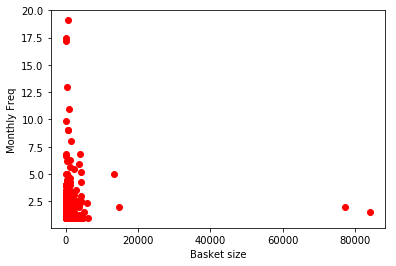

In [25]:
plt.scatter(df_plot['basketsize'],df_plot['avg_total_order_monthly'],color='r')
plt.xlabel('Basket size')
plt.ylabel('Monthly Freq')

In [26]:
!pip install seaborn==0.9.0

You are using pip version 10.0.1, however version 19.0.3 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [27]:
trace = go.Scatter( x = df_plot['basketsize'].loc[(df_plot['avg_total_order_monthly'] > 0 )],
                    y = df_plot['avg_total_order_monthly'].loc[(df_plot['avg_total_order_monthly']>0)],
    mode = 'markers'
)

data = [trace]

plotly.offline.iplot(data, filename='basic-scatter')

# Perbandingan market antara Germany dan France

In [28]:
df_monthly = pd.read_sql_query("""
select country, extract(month from invoice_date) as month, count(distinct invoice_no) from transaction
join customer on customer.customer_id = transaction.customer_id
where country in ('France','Germany') group by country, month""", cnx)

df_monthly.head()

,country,month,count
0,France,1.0,39
1,France,2.0,27
2,France,3.0,28
3,France,4.0,20
4,France,5.0,43


In [29]:
trace1 = go.Scatter(
x = df_monthly['month'].loc[(df_monthly['country']=='France')],
y = df_monthly['count'].loc[(df_monthly['country']=='France')],
)

trace2 = go.Scatter(
x = df_monthly['month'].loc[(df_monthly['country']=='Germany')],
y = df_monthly['count'].loc[(df_monthly['country']=='Germany')],)

data = [trace1, trace2]

plotly.offline.iplot(data, filename='basic-line')

In [30]:
df_monthly_2 = pd.read_sql_query("""
select country, extract(month from invoice_date) as month, count(distinct invoice_no) from transaction
join customer on customer.customer_id = transaction.customer_id group by month, country""", cnx)

df_monthly_2.describe()

,month,count
count,283.000000,283.000000
mean,6.554770,78.392226
std,3.445575,347.713256
min,1.000000,1.000000
25%,4.000000,2.000000
50%,7.000000,4.000000
75%,10.000000,9.000000
max,12.000000,2746.000000


In [31]:
trace3 = go.Scatter(
x = df_monthly_2['month'].loc[(df_monthly_2['country']=='France')],
y = df_monthly_2['count'].loc[(df_monthly_2['country']=='France')],)

trace4 = go.Scatter(
x = df_monthly_2['month'].loc[(df_monthly_2['country']=='Austria')],
y = df_monthly_2['count'].loc[(df_monthly_2['country']=='Austria')],)

trace5 = go.Scatter(
x = df_monthly_2['month'].loc[(df_monthly_2['country']=='Spain')],
y = df_monthly_2['count'].loc[(df_monthly_2['country']=='Spain')],)

trace6 = go.Scatter(
x = df_monthly_2['month'].loc[(df_monthly_2['country']=='Switzerland')],
y = df_monthly_2['count'].loc[(df_monthly_2['country']=='Switzerland')],)

data = [trace3, trace4, trace5, trace6]

plotly.offline.iplot(data, filename='basic-line')

In [32]:
df_timeframe = pd.read_sql_query("""
select 
case
    when extract(dow from invoice_date) = 0 then 'Sunday'
    when extract(dow from invoice_date) = 1 then 'Monday'
    when extract(dow from invoice_date) = 2 then 'Tuesday'
    when extract(dow from invoice_date) = 3 then 'Wednesday'
    when extract(dow from invoice_date) = 4 then 'Thursday'
    when extract(dow from invoice_date) = 5 then 'Friday'
    when extract(dow from invoice_date) = 6 then 'Saturday'
end as day_of_week_name,
case
    when extract(hour from invoice_date) between 0 and 10 then 'morning'
    when extract(hour from invoice_date) between 11 and 18 then 'afternoon'
    when extract(hour from invoice_date) between 18 and 24 then 'night' 
end as time_of_day,
count(distinct transaction.invoice_no) as total_invoice
from transaction join customer
on transaction.customer_id = customer.customer_id
group by 1,2
""", cnx)

df_timeframe.head()

,day_of_week_name,time_of_day,total_invoice
0,Friday,afternoon,2424
1,Friday,morning,920
2,Friday,night,10
3,Monday,afternoon,2774
4,Monday,morning,736


In [33]:
traceMorning = go.Scatter(
x = df_timeframe['day_of_week_name'].loc[(df_timeframe['time_of_day']=='morning')],
y = df_timeframe['total_invoice'].loc[(df_timeframe['time_of_day']=='morning')],)

traceAfternoon = go.Scatter(
x = df_timeframe['day_of_week_name'].loc[(df_timeframe['time_of_day']=='afternoon')],
y = df_timeframe['total_invoice'].loc[(df_timeframe['time_of_day']=='afternoon')],)

traceNight = go.Scatter(
x = df_timeframe['day_of_week_name'].loc[(df_timeframe['time_of_day']=='night')],
y = df_timeframe['total_invoice'].loc[(df_timeframe['time_of_day']=='night')],)



data = [traceMorning, traceAfternoon, traceNight]

plotly.offline.iplot(data, filename='basic-line')

In [34]:
temp = pd.read_sql_query("""
select customer_id, extract(day from invoice_date) as tgl, count(invoice_date) 
from "transaction" where customer_id is not null
group by 1,2 """, cnx)

temp.head()

,customer_id,tgl,count
0,12346,18.0,2
1,12347,2.0,22
2,12347,7.0,66
3,12347,9.0,18
4,12347,26.0,29


In [35]:
df_profiling = pd.merge(temp, tabulation, how='inner')
df_profiling.head()

,customer_id,tgl,count,country,recency_level,frequency_level,monitize_level
0,12347,2.0,22,Iceland,high,high,high
1,12347,7.0,66,Iceland,high,high,high
2,12347,9.0,18,Iceland,high,high,high
3,12347,26.0,29,Iceland,high,high,high
4,12347,31.0,47,Iceland,high,high,high


In [36]:
df_profiling.loc[(df_profiling['recency_level'] == 'high') & (df_profiling['frequency_level'] == 'high') & (df_profiling['monitize_level'] == 'high'), 'profiling'] = 'HHH'
df_profiling.loc[(df_profiling['recency_level'] == 'high') & (df_profiling['frequency_level'] == 'high') & (df_profiling['monitize_level'] == 'low'), 'profiling'] = 'HHL'
df_profiling.loc[(df_profiling['recency_level'] == 'high') & (df_profiling['frequency_level'] == 'low') & (df_profiling['monitize_level'] == 'high'), 'profiling'] = 'HLH'
df_profiling.loc[(df_profiling['recency_level'] == 'high') & (df_profiling['frequency_level'] == 'low') & (df_profiling['monitize_level'] == 'low'), 'profiling'] = 'HLL'
df_profiling.loc[(df_profiling['recency_level'] == 'low') & (df_profiling['frequency_level'] == 'high') & (df_profiling['monitize_level'] == 'high'), 'profiling'] = 'LHH'
df_profiling.loc[(df_profiling['recency_level'] == 'low') & (df_profiling['frequency_level'] == 'high') & (df_profiling['monitize_level'] == 'low'), 'profiling'] = 'LHL'
df_profiling.loc[(df_profiling['recency_level'] == 'low') & (df_profiling['frequency_level'] == 'low') & (df_profiling['monitize_level'] == 'high'), 'profiling'] = 'LLH'
df_profiling.loc[(df_profiling['recency_level'] == 'low') & (df_profiling['frequency_level'] == 'low') & (df_profiling['monitize_level'] == 'low'), 'profiling'] = 'LLL'
df_profiling.head()

,customer_id,tgl,count,country,recency_level,frequency_level,monitize_level,profiling
0,12347,2.0,22,Iceland,high,high,high,HHH
1,12347,7.0,66,Iceland,high,high,high,HHH
2,12347,9.0,18,Iceland,high,high,high,HHH
3,12347,26.0,29,Iceland,high,high,high,HHH
4,12347,31.0,47,Iceland,high,high,high,HHH


In [37]:
df_profil= df_profiling.groupby(['profiling','tgl'], as_index = False).sum()
df_profil.head()


,profiling,tgl,customer_id,count
0,HHH,1.0,1324114,1940
1,HHH,2.0,1185067,2330
2,HHH,3.0,799134,1357
3,HHH,4.0,1268351,2691
4,HHH,5.0,1302520,2905


In [38]:
print("count of HHH", len(df_profil[df_profil['profiling'] == 'HHH']))
print("count of HHL", len(df_profil[df_profil['profiling'] == 'HHL']))
print("count of HLH", len(df_profil[df_profil['profiling'] == 'HLH']))
print("count of HLL", len(df_profil[df_profil['profiling'] == 'HLL']))
print("count of LHH", len(df_profil[df_profil['profiling'] == 'LHH']))
print("count of LHL", len(df_profil[df_profil['profiling'] == 'LHL']))
print("count of LLH", len(df_profil[df_profil['profiling'] == 'LLH']))
print("count of LLL", len(df_profil[df_profil['profiling'] == 'LLL']))

count of HHH 31
count of HHL 31
count of HLH 31
count of HLL 31
count of LHH 31
count of LHL 31
count of LLH 31
count of LLL 31


In [39]:
import plotly.plotly as py
from plotly.grid_objs import Grid, Column
from plotly.tools import FigureFactory as ff
import plotly.graph_objs as go
plotly.offline.init_notebook_mode(connected=True)

trace1 = go.Scatter(
x = df_profil['tgl'].loc[(df_profil['profiling']=='HHH')],
y = df_profil['count'].loc[(df_profil['profiling']=='HHH')],
)

trace2 = go.Scatter(
x = df_profil['tgl'].loc[(df_profil['profiling']=='HHL')],
y = df_profil['count'].loc[(df_profil['profiling']=='HHL')],)

trace3 = go.Scatter(
x = df_profil['tgl'].loc[(df_profil['profiling']=='HLH')],
y = df_profil['count'].loc[(df_profil['profiling']=='HLH')],
)

trace4 = go.Scatter(
x = df_profil['tgl'].loc[(df_profil['profiling']=='HLL')],
y = df_profil['count'].loc[(df_profil['profiling']=='HLL')],)

trace5 = go.Scatter(
x = df_profil['tgl'].loc[(df_profil['profiling']=='LHH')],
y = df_profil['count'].loc[(df_profil['profiling']=='LHH')],
)

trace6 = go.Scatter(
x = df_profil['tgl'].loc[(df_profil['profiling']=='LHL')],
y = df_profil['count'].loc[(df_profil['profiling']=='LHL')],)

trace7 = go.Scatter(
x = df_profil['tgl'].loc[(df_profil['profiling']=='LLH')],
y = df_profil['count'].loc[(df_profil['profiling']=='LLH')],
)

trace8 = go.Scatter(
x = df_profil['tgl'].loc[(df_profil['profiling']=='LLL')],
y = df_profil['count'].loc[(df_profil['profiling']=='LLL')],)

data = [trace1, trace2, trace3, trace4, trace5, trace6, trace7, trace8]

plotly.offline.iplot(data, filename='basic-line')

# Nama Barang yang Banyak dibeli di setiap Profil

In [40]:
# Jawaban no 2

stock = pd.read_sql_query("""
select transaction.customer_id, product.stock_code, product.description, transaction.quantity from transaction
join product on transaction.stock_code = product.stock_code where transaction.customer_id is not null 
group by 1,2,3,4""", cnx)

stock.head()

,customer_id,stock_code,description,quantity
0,12346,23166,MEDIUM CERAMIC TOP STORAGE JAR,-74215
1,12346,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215
2,12347,16008,SMALL FOLDING SCISSOR(POINTED EDGE),24
3,12347,17021,NAMASTE SWAGAT INCENSE,36
4,12347,20665,RED RETROSPOT PURSE,6


In [41]:
df_profils = df_profiling[['customer_id','tgl','count','profiling']]
df_profils.head()

,customer_id,tgl,count,profiling
0,12347,2.0,22,HHH
1,12347,7.0,66,HHH
2,12347,9.0,18,HHH
3,12347,26.0,29,HHH
4,12347,31.0,47,HHH


In [42]:
jimmy = pd.merge(df_profils,stock,how='inner')
jimmy.head()

,customer_id,tgl,count,profiling,stock_code,description,quantity
0,12347,2.0,22,HHH,16008,SMALL FOLDING SCISSOR(POINTED EDGE),24
1,12347,2.0,22,HHH,17021,NAMASTE SWAGAT INCENSE,36
2,12347,2.0,22,HHH,20665,RED RETROSPOT PURSE,6
3,12347,2.0,22,HHH,20719,WOODLAND CHARLOTTE BAG,10
4,12347,2.0,22,HHH,20780,BLACK EAR MUFF HEADPHONES,12


In [43]:
len(jimmy['profiling'].unique())

8

In [44]:
jimmy_2 = jimmy.groupby(['description','profiling'], as_index = False)['quantity'].sum()
jimmy_2.head()

,description,profiling,quantity
0,4 PURPLE FLOCK DINNER CANDLES,HHH,42
1,4 PURPLE FLOCK DINNER CANDLES,HHL,61
2,4 PURPLE FLOCK DINNER CANDLES,HLL,4
3,4 PURPLE FLOCK DINNER CANDLES,LHH,687
4,4 PURPLE FLOCK DINNER CANDLES,LHL,293


In [45]:
jimmy_2.groupby('profiling',as_index=False)['quantity','description'].max()

,profiling,quantity,description
0,HHH,34940,ZINC WIRE SWEETHEART LETTER TRAY
1,HHL,22672,check
2,HLH,1872,ZINC WIRE SWEETHEART LETTER TRAY
3,HLL,4038,check
4,LHH,335264,check
5,LHL,33408,check
6,LLH,3046,ZINC WIRE SWEETHEART LETTER TRAY
7,LLL,786,ZINC WIRE SWEETHEART LETTER TRAY
